## plausibiliteit op basis vanuit neerslag gevens in bui-bestanden en waterstanden en afvoeren in opgeslagen in his-bestanden

Deze notebook bevat informatie hoe het mogelijk is om .his- en .bui-bestanden uit te lezen binnen Python en op welke manier hieruit de plausibiliteitsuit af te leiden. Een aantal functies worden hierbij toegelicht. Waarbij elke functie in detail is beschreven in de toebehorende `docstring`.

In [1]:
import hkvsobekpy as hkv
import geopandas as gpd
import os

Ook bepalen we de input bestanden.

In [4]:
bui_file = r'D:\Projects\Pr\3651.10\Toeleveringen\08122017_AnneJopen_wetransfer\T100St2.bui'
his_folder = r'D:\Projects\Pr\3651.10\Toeleveringen\08122017_AnneJopen_wetransfer'
shp_file = r'D:\Projects\Pr\3651.10\Toeleveringen\08122017_AnneJopen_wetransfer\Sbk_FGrPt_n.dbf'

Naast het .his-bestand is er een .shp-bestand gedefinieerd met een bijbehorende .dbf-bestand. De kolom met naam van his-file, locatie en parameter die hierin staan gedefinieerd worden gebruikt voor het inlezen van de periode in een his-bestand. 
Het is daarom van belang dat deze namen correct zijn. 

De shp-file kunnen we als volgt inlezen naar een `GeoDataFrame` en vervolgens plotten in figuur (de `shp`) en tabel (de `dbf`)

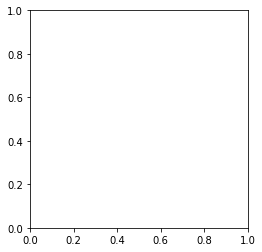

In [5]:
gdf = gpd.read_file(shp_file)
gdf.plot()

In [6]:
gdf.head()

,ID________,NAME______,TYPE______,PARENTID__,USERID____,X_________,Y_________,Z_________,COLOR_____,HIS_FILE,LOCATIES,PARAMETERS,geometry
0,calc_1,0.000000000000000,Flow - Fixed Calculation Point,SBK_GRIDPOINTFIXED,,80423.3177,454347.0958,0.0,8388863.0,calcpnt,calc_1,Waterlevel mean (m AD,None
1,calc_2,0.000000000000000,Flow - Fixed Calculation Point,SBK_GRIDPOINTFIXED,,80427.9324,454338.2494,0.0,8388863.0,calcpnt,calc_2,Waterlevel mean (m AD,None
2,calc_4,24.699999999999999,Flow - Fixed Calculation Point,SBK_GRIDPOINTFIXED,,81859.9993,456551.2446,0.0,8388863.0,reachseg,1,Waterlevel slope MEA,None
3,calc_6,27.000000000000000,Flow - Fixed Calculation Point,SBK_GRIDPOINTFIXED,,82463.6157,456893.4409,0.0,8388863.0,reachseg,1,Discharge mean (m3/s),None


Te zien is dat de dbf behorende bij de shapefile heeft de kolom `his_file` met daarin de namen van de daarbij behorende his-file. In de `locaties` kolom staan de locaties of interest en in de kolom `parameters` staan de parameter welke van belang is. 

Deze drie koloms worden als shp_key gedefineerd:

In [7]:
shp_hiskey = 'HIS_FILE'
shp_locationkey = 'LOCATIES'
shp_parameterkey = 'PARAMETERS'

Voor demo doeleinden werken we verder met de eigenschappen van deze keys voor regel 2

In [8]:
row = 2
his_file = gdf[shp_hiskey].iloc[row]
location = gdf[shp_locationkey].iloc[row]
parameter = gdf[shp_parameterkey].iloc[row]

# selection of location and parameter through `read_his`
# hkv.read_his.LeesMetadata(os.path.join(his_folder,'{0}.his'.format(his_file)))
# parameter = hkv.read_his.KrijgParameters()[0]
# locatie = hkv.read_his.KrijgLokaties()[40]

print(' his_file : {0}\n location : {1}\n parameter : {2}'.format(his_file, location, parameter))

 his_file : reachseg
 location : 1
 parameter : Waterlevel slope MEA


Met de volgende commando kunnen we vervolgens een series uitlezen uit dit gedefineerde his-bestand

In [10]:
df_his = hkv.plausibility.read_his_series(his_file=his_file,
                                          location=location,
                                          parameter=parameter,
                                          his_folder=his_folder, normalize_by_unicode=True, include_simularity=True, sequence_simularity=0.82)
df_his.head()

Normalized unicode Waterlevel slope MEA matches Waterlevel slope mea


location,1
parameter,Waterlevel slope mea
1950-01-01 00:00:00,-999.999023
1950-01-01 00:15:00,-999.999023
1950-01-01 00:30:00,-999.999023
1950-01-01 00:45:00,-999.999023
1950-01-01 01:00:00,-999.999023


Informatie in het bui-bestand kunnen we op de volgende manier inlezen.

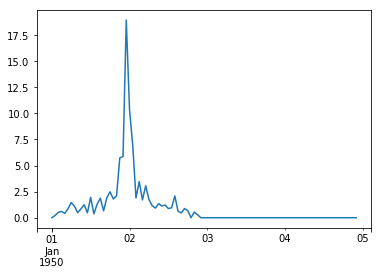

In [11]:
# parse bui-file to pandas dataframe
df_bui = hkv.read_bui(bui_file)

# location to query
bui_location = 'De Bilt'
# yyyy-mm-dd:yyyy-mm-dd
df_bui.loc['1950-01-01':'1950-01-08',bui_location].plot()

Het resultaat is een DataFrame met in de kolommen de neerslag in mm voor de stations en in de rijen de waarnemingstijdstappen

Om een combinatie plot te maken van bui-bestand en een his-bestand is het allereerst van belang om een aantal eigenschappen in te lezen.

In [12]:
bui_locations = ['De Bilt','Verdamping','De Bilt Test']
df_bui_sel, start_his, end_his, df_bui_std, df_his_std = hkv.plausibility.prepare_bui_his(df_his, df_bui, bui_locations)

In [13]:
out_folder =r'C:\TOOL_waterstandstatistiek\hkvsobekpy\Data\output\plausib_boezem_out'

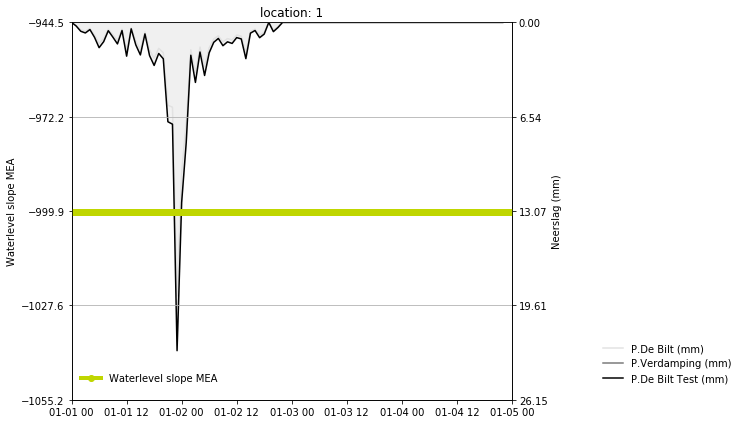

In [14]:
hkv.plausibility.plot_bui_his(df_his, df_bui_sel, start_his, end_his, 
                              df_bui_std, df_his_std, his_file, 
                              parameter, location, out_folder, 
                              savefigure=False)

En in tabel formaat

In [ ]:
df_bui_his = hkv.plausibility.table_bui_his(df_his, df_bui_sel)
df_bui_his.head()

Al het bovenstaande kan ook automatsich weggeschreven worden naar de output folder. Binnen de output folder worden de afgeleide figuren weggeschreven.

In [ ]:
hkv.plausibility.EnsembleRunner(shp_file, bui_file, his_folder, out_folder, shp_hiskey, shp_locationkey, shp_parameterkey)